In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,  RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import Conv1D, RNN, GRU, LSTM, Dense, Input, BatchNormalization, Dropout, concatenate, Flatten, add, MaxPool1D, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import Huber 
from tensorflow.keras.regularizers import L1
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow import one_hot
import tensorflow as tf
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import math
import random
import warnings
import itertools

In [5]:
warnings.filterwarnings('ignore')

In [6]:
path = 'data/' #데이터 저장된 폴더

# 함수 정의

In [7]:
def feature_extraction(original_df:pd.DataFrame):
    df = original_df.copy()
    
    #abnormal value adjustment
    df['solar_amt'] = np.where(surface['solar_amt'] < 0, 0, surface['solar_amt'])
    df['solar_time'] = np.where(surface['solar_time'] < 0, 0, surface['solar_time'])
    df['rain'] = np.where(surface['rain'] < 0, 0, surface['rain'])
    df['tf_rain'] = np.where(surface['tf_rain'] < 0, 0, surface['tf_rain'])/60 #0~1
    df['humid'] = np.where(surface['humid'] < 0, 0, surface['humid'])/100 #0~1
    df['snow'] = np.where(surface['snow'] == -99.9, 0, surface['snow'])
    
    #preprocessing
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / df['month'].map(lambda x: month_days[x-1]))
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / df['month'].map(lambda x: month_days[x-1]))
    
    #difference
    df['temp_diff'] = df['temp'] - df['dp_temp']
    
    #interaction
    interaction_cols = ["temp", "dp_temp", "humid", "wind", "solar_amt"]
    interaction_terms = []
    for terms in itertools.combinations(interaction_cols, 2):
        term_name = '_'.join(terms)
        df[term_name] = df[list(terms)].product(axis=1)
    df['temp_dp'] = df['temp']*df['dp_temp']
    
    return df

In [8]:
def process_group(group, wthr):
    group = group.reset_index(drop=True)
    group[wthr+'_diff'] = group[wthr].diff()
    group['after_'+wthr] = 0
    index_list = group[group[wthr+'_diff'] < 0].index
    for index in index_list:
        for i in range(24):
            if index + i < len(group):
                group.loc[index + i, 'after_'+wthr] = i + 1
    return group

def add_lag(original_df:pd.DataFrame, lag_cols: list, pct_cols: list, lags: list):
    # lag_cols: lag 넣을 변수들 목록 
    # pct_cols: percentage change lag 넣을 변수들 목록 
    # lags: 어느 lag들 넣을건지
    
    df = original_df.copy()
    
    #lag
    for col in pct_cols:
        for i in lags:
            df[col + '_pct_' + str(i)] = df.groupby('area')[col].pct_change(periods=i)
    for col in lag_cols:
        for i in lags:
            df[col + '_lag_' + str(i)] = df.groupby('area')[col].shift(periods=i)

    #cumulative 
    df['rain_mask'] = (df['tf_rain'] != 0).astype(int)
    df['rain_group'] = (df['rain_mask'].diff() < 0).astype(int).cumsum()
    df['rain_count'] = df.groupby(['area', 'rain_group'])['rain_mask'].apply(lambda x: x.cumsum() * x)
    df.drop(['rain_mask', 'rain_group'], axis=1, inplace=True)
    df['solar_amt_sum'] = df.groupby('area')['solar_amt'].rolling(window=3).sum().reset_index(drop=True)
    df = df.groupby('area').apply(process_group, wthr="snow")
    df.drop('snow_diff', axis=1, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df = df.groupby('area').apply(process_group, wthr="rain")
    df.drop('rain_diff', axis=1, inplace = True)
    df.reset_index(drop = True, inplace = True)

    #interaction
    df["temp_after_snow"] = df[["temp", "after_snow"]].product(axis=1)
    df["solar_amt_after_snow"] = df[["solar_amt", "after_snow"]].product(axis=1)
    df["temp_after_rain"] = df[["temp", "after_rain"]].product(axis=1)
    df["solar_amt_after_rain"] = df[["solar_amt", "after_rain"]].product(axis=1)
    
    return df

In [9]:
def make_weather_df(original_df:pd.DataFrame, weather:str, adj:bool, fog_split:dict):
    # adj: 동균이가 제안한 snow adjustment 할건지 
    # fog split: fog 변수 어떻게 분할한건지 
    
    df = original_df.copy()
    if adj == True:
        df['solar_amt'] = df['solar_amt'].div(1 + np.abs(df['snow']))
        df['temp'] = df['temp'].div(1 + np.abs(df['snow'])*8)
    if weather == 'spring':
        m_list = range(2, 5)
    elif weather == 'summer':
        m_list = range(5, 8)
    elif weather == 'fall':
        m_list = range(8, 11)
    elif weather == 'winter':
        m_list = [range(11, 13)] + [1] 
    
    df['fog'] = surface['fog'].replace(fog_split)
    df = pd.get_dummies(df, columns = ['fog'])
    
    if weather in ['summer', 'fall']:
        snow_cols = [x for x in df.columns if x.endswith('snow')]
        df.drop(snow_cols, axis = 1, inplace = True)
        
    return df[df['month'].isin(m_list)].reset_index(drop = True)

# 데이터 

In [10]:
surface = pd.read_csv('GAN_train2.csv')
surface

,area,year,month,day,hour,temp,dp_temp,humid,wind,rain,tf_rain,land_temp,solar_amt,solar_time,snow,fog
0,1,A,2,1,0,-9.9,-10.7,93.9,0.6,0.0,0.0,-1.3,0.000000,0.000000,-99.9,H
1,1,A,2,1,1,-10.8,-11.6,93.8,0.6,0.0,0.0,-1.5,0.000000,0.000000,-99.9,H
2,1,A,2,1,2,-11.4,-12.1,94.6,0.7,0.0,0.0,-1.7,0.000000,0.000000,-99.9,H
3,1,A,2,1,3,-11.6,-12.5,93.4,0.6,0.0,0.0,-1.8,0.000000,0.000000,-99.9,H
4,1,A,2,1,4,-11.8,-12.7,93.0,0.6,0.0,0.0,-2.0,0.000000,0.000000,-99.9,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438235,10,F,1,31,19,5.7,-7.2,39.2,3.9,0.0,0.0,3.6,0.008187,0.375462,-99.9,C
438236,10,F,1,31,20,5.2,-8.0,38.1,4.9,0.0,0.0,2.7,0.000000,0.000000,-99.9,C
438237,10,F,1,31,21,4.6,-7.9,39.8,6.6,0.0,0.0,2.2,0.000000,0.000000,-99.9,C
438238,10,F,1,31,22,3.6,-6.6,47.4,7.1,0.0,0.0,1.6,0.000000,0.000000,-99.9,C


In [11]:
surface = pd.read_csv('GAN_train2.csv')
surface_fe = feature_extraction(original_df = surface) #lag 안한 변수만 추가 
surface_fe 

,area,year,month,day,hour,temp,dp_temp,humid,wind,rain,...,temp_humid,temp_wind,temp_solar_amt,dp_temp_humid,dp_temp_wind,dp_temp_solar_amt,humid_wind,humid_solar_amt,wind_solar_amt,temp_dp
0,1,A,2,1,0,-9.9,-10.7,0.939,0.6,0.0,...,-9.2961,-5.94,-0.000000,-10.0473,-6.42,-0.000000,0.5634,0.000000,0.00000,105.93
1,1,A,2,1,1,-10.8,-11.6,0.938,0.6,0.0,...,-10.1304,-6.48,-0.000000,-10.8808,-6.96,-0.000000,0.5628,0.000000,0.00000,125.28
2,1,A,2,1,2,-11.4,-12.1,0.946,0.7,0.0,...,-10.7844,-7.98,-0.000000,-11.4466,-8.47,-0.000000,0.6622,0.000000,0.00000,137.94
3,1,A,2,1,3,-11.6,-12.5,0.934,0.6,0.0,...,-10.8344,-6.96,-0.000000,-11.6750,-7.50,-0.000000,0.5604,0.000000,0.00000,145.00
4,1,A,2,1,4,-11.8,-12.7,0.930,0.6,0.0,...,-10.9740,-7.08,-0.000000,-11.8110,-7.62,-0.000000,0.5580,0.000000,0.00000,149.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438235,10,F,1,31,19,5.7,-7.2,0.392,3.9,0.0,...,2.2344,22.23,0.046667,-2.8224,-28.08,-0.058947,1.5288,0.003209,0.03193,-41.04
438236,10,F,1,31,20,5.2,-8.0,0.381,4.9,0.0,...,1.9812,25.48,0.000000,-3.0480,-39.20,-0.000000,1.8669,0.000000,0.00000,-41.60
438237,10,F,1,31,21,4.6,-7.9,0.398,6.6,0.0,...,1.8308,30.36,0.000000,-3.1442,-52.14,-0.000000,2.6268,0.000000,0.00000,-36.34
438238,10,F,1,31,22,3.6,-6.6,0.474,7.1,0.0,...,1.7064,25.56,0.000000,-3.1284,-46.86,-0.000000,3.3654,0.000000,0.00000,-23.76


In [12]:
#'temp', 'dp_temp', 'humid' 3개 변수에 대해 1, 2, 12, 24 lag 변수와 해당 lag의 percentage change 추가 + 기타 lag 변수들과 interaction들 추가
surface_lag = add_lag(original_df = surface_fe, 
                      lag_cols = ['temp', 'dp_temp', 'humid', 'wind', 'rain', 'tf_rain', 'solar_amt', 'solar_time'], #lag 추가하는 변수들 
                      pct_cols = ['temp', 'dp_temp', 'humid'], #percetnage change 추가하는 변수들 
                      lags = [1, 3, 6, 12, 24]) #추가 lag들 
surface_lag 

,area,year,month,day,hour,temp,dp_temp,humid,wind,rain,...,solar_time_lag_12,solar_time_lag_24,rain_count,solar_amt_sum,after_snow,after_rain,temp_after_snow,solar_amt_after_snow,temp_after_rain,solar_amt_after_rain
0,1,A,2,1,0,-9.9,-10.7,0.939,0.6,0.0,...,NaN,NaN,0,NaN,0,0,-0.0,0.0,-0.0,0.0
1,1,A,2,1,1,-10.8,-11.6,0.938,0.6,0.0,...,NaN,NaN,0,NaN,0,0,-0.0,0.0,-0.0,0.0
2,1,A,2,1,2,-11.4,-12.1,0.946,0.7,0.0,...,NaN,NaN,0,0.000000,0,0,-0.0,0.0,-0.0,0.0
3,1,A,2,1,3,-11.6,-12.5,0.934,0.6,0.0,...,NaN,NaN,0,0.000000,0,0,-0.0,0.0,-0.0,0.0
4,1,A,2,1,4,-11.8,-12.7,0.930,0.6,0.0,...,NaN,NaN,0,0.000000,0,0,-0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438235,10,F,1,31,19,5.7,-7.2,0.392,3.9,0.0,...,0.067484,0.230957,0,1.028187,0,0,0.0,0.0,0.0,0.0
438236,10,F,1,31,20,5.2,-8.0,0.381,4.9,0.0,...,0.000000,0.000000,0,0.098187,0,0,0.0,0.0,0.0,0.0
438237,10,F,1,31,21,4.6,-7.9,0.398,6.6,0.0,...,0.500000,0.000000,0,0.008187,0,0,0.0,0.0,0.0,0.0
438238,10,F,1,31,22,3.6,-6.6,0.474,7.1,0.0,...,1.000000,0.000000,0,0.000000,0,0,0.0,0.0,0.0,0.0


In [13]:
#summer: 맑음 / 비 / 기타 구분 & snow에 대한 adjustment x 
f = {x:3 for x in surface.fog.unique()} 
f.update({'C': 1, 'R':2})
summer = make_weather_df(original_df = surface_lag, 
                         weather = 'summer', 
                         adj = False, 
                         fog_split = f)

In [14]:
summer

,area,year,month,day,hour,temp,dp_temp,humid,wind,rain,...,solar_time_lag_12,solar_time_lag_24,rain_count,solar_amt_sum,after_rain,temp_after_rain,solar_amt_after_rain,fog_1,fog_2,fog_3
0,1,A,5,1,0,17.6,12.0,0.698,0.7,0.0,...,1.0,0.0,0,0.00,0,0.0,0.00,0,0,1
1,1,A,5,1,1,15.9,12.3,0.792,0.7,0.0,...,1.0,0.0,0,0.00,0,0.0,0.00,0,0,1
2,1,A,5,1,2,15.0,12.3,0.840,0.8,0.0,...,1.0,0.0,0,0.00,0,0.0,0.00,0,0,1
3,1,A,5,1,3,15.1,8.2,0.654,1.7,0.0,...,1.0,0.0,0,0.00,0,0.0,0.00,0,0,1
4,1,A,5,1,4,16.1,1.6,0.375,2.7,0.0,...,1.0,0.0,0,0.00,0,0.0,0.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110395,10,E,7,31,19,29.4,25.9,0.816,4.6,0.0,...,0.1,0.3,0,2.67,13,382.2,1.43,1,0,0
110396,10,E,7,31,20,28.6,26.2,0.873,3.9,0.0,...,0.0,0.0,0,0.96,14,400.4,0.00,1,0,0
110397,10,E,7,31,21,28.2,26.1,0.886,3.5,0.0,...,0.1,0.0,0,0.11,15,423.0,0.00,1,0,0
110398,10,E,7,31,22,28.0,26.2,0.901,4.5,0.0,...,0.0,0.0,0,0.00,16,448.0,0.00,1,0,0


In [15]:
# roup time series code
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class GroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [17]:
train_df = summer[summer['year'] != 'E'].reset_index(drop = True)
test_df = summer[summer['year'] == 'E'].reset_index(drop = True)

In [18]:
# 검증 데이터
surface = pd.read_csv('imputed_test_data.csv')
surface['area'] = surface['area'].astype(int)
surface['month'] = surface['month'].astype(int)
surface['day'] = surface['day'].astype(int)
surface['hour'] = surface['hour'].astype(int)
surface_fe = feature_extraction(original_df = surface)
#'temp', 'dp_temp', 'humid' 3개 변수에 대해 1, 2, 12, 24 lag 변수와 해당 lag의 percentage change 추가 + 기타 lag 변수들과 interaction들 추가
surface_lag = add_lag(original_df = surface_fe, 
                      lag_cols = ['temp', 'dp_temp', 'humid', 'wind', 'rain', 'tf_rain', 'solar_amt', 'solar_time'], #lag 추가하는 변수들 
                      pct_cols = ['temp', 'dp_temp', 'humid'], #percetnage change 추가하는 변수들 
                      lags = [1, 3, 6, 12, 24]) #추가 lag들 
#summer: 맑음 / 비 / 기타 구분 & snow에 대한 adjustment x 
f = {x:3 for x in surface.fog.unique()} 
f.update({'C': 1, 'R':2})
summer_test = make_weather_df(original_df = surface_lag, 
                         weather = 'summer', 
                         adj = False, 
                         fog_split = f)

In [62]:
summer_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624 entries, 0 to 6623
Data columns (total 92 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area                  6624 non-null   int32  
 1   year                  6624 non-null   object 
 2   month                 6624 non-null   int32  
 3   day                   6624 non-null   int32  
 4   hour                  6624 non-null   int32  
 5   temp                  6624 non-null   float64
 6   dp_temp               6624 non-null   float64
 7   humid                 6624 non-null   float64
 8   wind                  6624 non-null   float64
 9   rain                  6624 non-null   float64
 10  tf_rain               6624 non-null   float64
 11  solar_amt             6624 non-null   float64
 12  solar_time            6624 non-null   float64
 13  hour_sin              6624 non-null   float64
 14  hour_cos              6624 non-null   float64
 15  day_cos              

In [64]:
X_r_test = summer_test.drop(['area','year', 'month','day','hour', 'day_cos', 'day_sin'], axis =1)

Day 변수 제거?

In [51]:
X_feature = train_df.drop(['area','year','land_temp', 'month','day','hour', 'day_cos', 'day_sin'], axis =1)
y_target = train_df['land_temp']
X_test = test_df.drop(['area','year','land_temp', 'month','day','hour', 'day_cos', 'day_sin'], axis = 1)
y_test = test_df['land_temp']
groups = train_df['year'].reset_index(drop=True).values

## 1. 단일 모형 with lightGBM (채택 x)

In [52]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss

param_lgbm = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators', 300, 1000, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 1),
    'min_child_samples': hp.quniform('min_child_samples', 10, 30, 1),
    'subsample': hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}
def objective(params):
    model = LGBMRegressor(
        max_depth = int(params['max_depth']),
        num_leaves = int(params['num_leaves']),
        min_child_samples = int(params['min_child_samples']),
        subsample = float(params['subsample']),
        n_estimators = int(params['n_estimators']),
        learning_rate = float(params['learning_rate']),
        colsample_bytree = float(params['colsample_bytree']),
        reg_alpha = float(params['reg_alpha']),
        reg_lambda = float(params['reg_lambda']),
        n_jobs = -1,
        random_state = 1
    )
    
    gscv = GroupTimeSeriesSplit(n_splits=3)
    mae = []
    
    for train_index, valid_index in gscv.split(X_feature, groups=groups):
        X_train, X_valid = X_feature.loc[train_index], X_feature.loc[valid_index]
        y_train, y_valid = y_target.loc[train_index], y_target.loc[valid_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        mae.append(mean_absolute_error(y_valid, y_pred))
    
    return{'loss' : np.mean(mae), 'status' : STATUS_OK}

best = fmin(fn = objective, 
            space = param_lgbm, 
            algo = tpe.suggest,
            return_argmin = False, # hp.choice의 경우 값 대신 index를 반환 > False
            max_evals = 100, 
            trials = Trials(), 
            # early_stop_fn = no_progress_loss(20), # 20회동안 개선되지 않으면 조기 중지 
            rstate = np.random.default_rng(42))

print("Best hyperparameters : ", best)

100%|██████████████████████████████████████████████| 100/100 [11:55<00:00,  7.16s/trial, best loss: 1.7867270808212563]
Best hyperparameters :  {'colsample_bytree': 0.8558412298684166, 'learning_rate': 0.027479253439389135, 'max_depth': 14.0, 'min_child_samples': 30.0, 'n_estimators': 999.0, 'num_leaves': 48.0, 'reg_alpha': 0.5487965807035248, 'reg_lambda': 0.2333148764723296, 'subsample': 0.88560725147302}


In [53]:
# test MAE of Full model(with group_cv = 3)
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])
best['subsample'] = float(best['subsample'])
best['n_estimators'] = int(best['n_estimators'])
best['learning_rate'] = float(best['learning_rate'])
best['colsample_bytree'] = float(best['colsample_bytree'])
best['reg_alpha'] = float(best['reg_alpha'])
best['reg_lambda'] = float(best['reg_lambda'])

model1 = LGBMRegressor(random_state = 1, **best)
model1.fit(X_feature, y_target, verbose = False)
y_pred = model1.predict(X_test)
mean_absolute_error(y_test, y_pred) 

1.6501274496610818

In [57]:
# train MAE of Full model(with group_cv = 3)
y_pred1 = model1.predict(X_feature)
mean_absolute_error(y_target, y_pred2) 

1.1700227508831107

[('temp_lag_24', 1497), ('humid_lag_12', 1320), ('temp', 1307), ('temp_lag_12', 1298), ('temp_pct_24', 1192), ('dp_temp_lag_24', 1165), ('solar_amt_lag_24', 1158), ('humid_lag_24', 1123), ('temp_pct_12', 1112), ('wind_lag_24', 1108)]


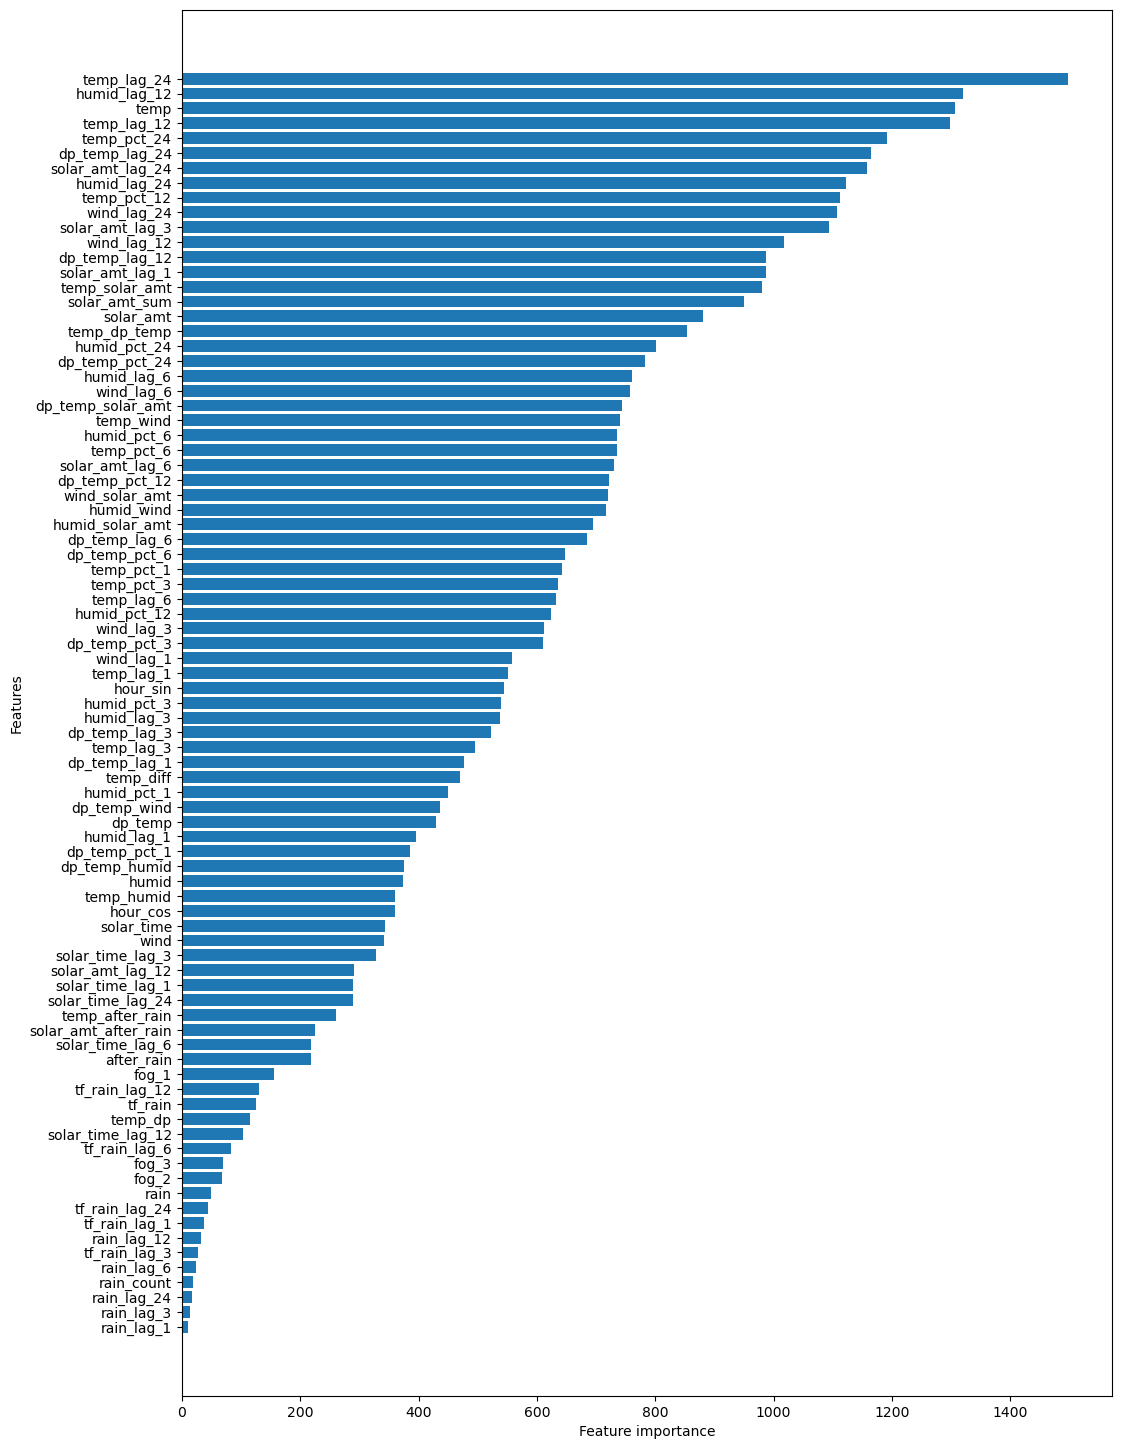

In [58]:
# feature importance
sorted_idx=np.argsort(model1.feature_importances_)
sorted_col=X_feature.columns[sorted_idx]
sorted_imp=model1.feature_importances_[sorted_idx].round(2)
feature_dict=dict(zip(sorted_col,sorted_imp))
feature_impc=list(feature_dict.items())[:-11:-1]
print(feature_impc)

sorted_col=sorted_col
sorted_imp=sorted_imp

plt.figure(figsize=(12, 18))
plt.barh(sorted_col,sorted_imp)
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.show()

In [65]:
y_test_pred1 = model1.predict(X_r_test)

## 2. lag 5개 + interaction term + lightgbm & ensemble (채택 X)

In [66]:
X_train = train_df.drop(['year','land_temp', 'month','day','hour', 'day_cos', 'day_sin'], axis =1)
y_train = train_df[['area', 'land_temp']]
X_test = test_df.drop(['year','land_temp', 'month','day','hour', 'day_cos', 'day_sin'], axis = 1)
y_test = test_df[['area', 'land_temp']]

In [67]:
# area 별로 분리 (1 - 10)
for i in range(1, 11):
    globals()['X_train'+str(i)] = X_train[X_train['area'] == i].reset_index(drop=True)
    globals()['y_train'+str(i)] = y_train[y_train['area'] == i].reset_index(drop=True)
    globals()['X_test'+str(i)] = X_test[X_test['area'] == i].reset_index(drop=True)
    globals()['y_test'+str(i)] = y_test[y_test['area'] == i].reset_index(drop=True)

    # 특성 변수와 타겟 변수 분리
    globals()['X_train'+str(i)] = globals()['X_train'+str(i)].drop(['area'], axis=1).reset_index(drop=True)
    globals()['y_train'+str(i)] = globals()['y_train'+str(i)]['land_temp'].reset_index(drop=True)

    # 테스트 데이터
    globals()['X_test'+str(i)] = globals()['X_test'+str(i)].drop(['area'], axis=1).reset_index(drop=True)
    globals()['y_test'+str(i)] = globals()['y_test'+str(i)]['land_temp'].reset_index(drop=True)

In [68]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import VotingRegressor

In [36]:
# without min_max_scaler
for i in range(1, 11):           

    # 시계열 교차 검증
    tscv = TimeSeriesSplit(n_splits=5)

    # Bayesian Optimization을 위한 탐색 공간 정의
    param_lgbm = {'regressor__learning_rate' : Real(0.01, 0.2, prior = 'log-uniform'),
                 'regressor__n_estimators' : Integer(500, 1500),
                 'regressor__max_depth': Integer(5, 30),
                 'regressor__num_leaves': Integer(40, 60),
                 'regressor__min_child_samples': Integer(10, 30),
                 'regressor__subsample': Real(0.8, 1.0, prior='uniform'),
                 'regressor__colsample_bytree': Real(0.8, 1.0, prior='uniform'),
                 'regressor__reg_alpha': Real(0.0, 1.0, prior='uniform'),
                 'regressor__reg_lambda': Real(0.0, 1.0, prior='uniform')
}

    # CatBoostRegressor를 포함한 TransformedTargetRegressor 생성
    model = TransformedTargetRegressor(regressor=LGBMRegressor(random_state=42, n_jobs=-1))


    bs_lgbm = BayesSearchCV(estimator=model,
                           search_spaces=param_lgbm, 
                           scoring='neg_mean_absolute_error',
                           cv=tscv, 
                           n_jobs=-1,
                           random_state=42, 
                           refit=True, 
                           return_train_score=True, 
                           optimizer_kwargs={'base_estimator': 'GP'}, 
                           verbose=1)

    # 모델 훈련 및 예측
    bs_lgbm.fit(globals()['X_train'+str(i)], globals()['y_train'+str(i)])
    print('Best hyperparameter'+str(i), ':', bs_lgbm.best_params_)
    print('Train MAE'+str(i), ':', -bs_lgbm.best_score_)

    # 테스트 데이터 예측
    y_pred = bs_lgbm.predict(globals()['X_test'+str(i)])
    print('Test MAE'+str(i), ':', mean_absolute_error(globals()['y_test'+str(i)], y_pred))

    # 최종 모델 저장
    globals()['model_lgbm'+str(i)] = bs_lgbm.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameter5 : OrderedDict([('regressor__colsample_bytree', 0.8), ('regressor__learning_rate', 0.023717677895963078), ('regressor__max_depth', 28), ('regressor__min_child_samples', 25), ('regressor__n_estimators', 665), ('regressor__num_leaves', 40), ('regressor__reg_alpha', 0.5849889352873602), ('regressor__reg_lambda', 0.38450089414825017), ('regressor__subsample', 0.8344131469837268)])
Train MAE5 : 1.8442735045695742
Test MAE5 : 1.4054067956675598
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fittin

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameter10 : OrderedDict([('regressor__colsample_bytree', 0.8), ('regressor__learning_rate', 0.01620666919195234), ('regressor__max_depth', 22), ('regressor__min_child_samples', 30), ('regressor__n_estimators', 1500), ('regressor__num_leaves', 40), ('regressor__reg_alpha', 1.0), ('regressor__reg_lambda', 1.0), ('regressor__subsample', 0.9

In [41]:
lgbm_models = []

for i in range(1, 11):    
    # pretrained model 추가
    lgbm_models.append(('lgbm_' + str(i), globals()['model_lgbm'+str(i)]))

# VotingRegressor ensemble model 생성
ensemble_model = VotingRegressor(estimators = lgbm_models)

# Fit the ensemble model

ensemble_X_train = pd.DataFrame()
ensemble_y_train = pd.DataFrame()

for i in range(1, 11):
    ensemble_X_train = pd.concat([ensemble_X_train, globals()['X_train'+str(i)]], axis=0)
    ensemble_y_train = pd.concat([ensemble_y_train, globals()['y_train'+str(i)]], axis=0)

ensemble_model.fit(ensemble_X_train, ensemble_y_train)
globals()['model_ensemble'] = ensemble_model
# 테스트 데이터 예측
predictions = []
for j in range(1, 11):
    temp = ensemble_model.predict(globals()['X_test'+str(j)])
    temp_mae = mean_absolute_error(temp, globals()['y_test'+str(j)])
    predictions.append(temp_mae)
print('Test MAE for Ensemble model :', np.mean(predictions))

Test MAE for Ensemble model : 1.6673819699513956


In [57]:
y_test_pred1 = ensemble_model.predict(X_r_test)

In [69]:
# with min_max_scaler
for i in range(1, 11):           

    # 시계열 교차 검증
    tscv = TimeSeriesSplit(n_splits=5)

    # Bayesian Optimization을 위한 탐색 공간 정의
    param_lgbm = {'regressor__learning_rate' : Real(0.01, 0.2, prior = 'log-uniform'),
                 'regressor__n_estimators' : Integer(500, 1500),
                 'regressor__max_depth': Integer(5, 30),
                 'regressor__num_leaves': Integer(40, 60),
                 'regressor__min_child_samples': Integer(10, 30),
                 'regressor__subsample': Real(0.8, 1.0, prior='uniform'),
                 'regressor__colsample_bytree': Real(0.8, 1.0, prior='uniform'),
                 'regressor__reg_alpha': Real(0.0, 1.0, prior='uniform'),
                 'regressor__reg_lambda': Real(0.0, 1.0, prior='uniform')
}

    # CatBoostRegressor를 포함한 TransformedTargetRegressor 생성
    model = TransformedTargetRegressor(regressor=LGBMRegressor(random_state=42, n_jobs=-1), transformer=MinMaxScaler())


    bs_lgbm = BayesSearchCV(estimator=model,
                           search_spaces=param_lgbm, 
                           scoring='neg_mean_absolute_error',
                           cv=tscv, 
                           n_jobs=-1,
                           random_state=42, 
                           refit=True, 
                           return_train_score=True, 
                           optimizer_kwargs={'base_estimator': 'GP'}, 
                           verbose=1)

    # 모델 훈련 및 예측
    bs_lgbm.fit(globals()['X_train'+str(i)], globals()['y_train'+str(i)])
    print('Best hyperparameter'+str(i), ':', bs_lgbm.best_params_)
    print('Train MAE'+str(i), ':', -bs_lgbm.best_score_)

    # 테스트 데이터 예측
    y_pred = bs_lgbm.predict(globals()['X_test'+str(i)])
    print('Test MAE'+str(i), ':', mean_absolute_error(globals()['y_test'+str(i)], y_pred))

    # 최종 모델 저장
    globals()['model_lgbm2'+str(i)] = bs_lgbm.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Best hyperparameter5 : OrderedDict([('regressor__colsample_bytree', 0.8), ('regressor__learning_rate', 0.01689615530040168), ('regressor__max_depth', 30), ('regressor__min_child_samples', 30), ('regressor__n_estimators', 1500), ('regressor__num_leaves', 40), ('regressor__reg_alpha', 0.7035958009085196), ('regressor__reg_lambda', 1.0), ('regressor__subsample', 0.8)])
Train MAE5 : 1.853773376828838
Test MAE5 : 1.3401956859878539
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidat

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameter10 : OrderedDict([('regressor__colsample_bytree', 0.8), ('regressor__learning_rate', 0.020037934375312875), ('regressor__max_depth', 29), ('regressor__min_child_samples', 28), ('regressor__n_estimators', 1500), ('regressor__num_leaves', 41), ('regressor__reg_alpha', 0.0), ('regressor__reg_lambda', 0.6170612490613971), ('regressor__subsample', 0.8)])
Train MAE10 : 1.7522329843231788
Test MAE10 : 1.268865301498624


In [70]:
lgbm_models = []

for i in range(1, 11):    
    # pretrained model 추가
    lgbm_models.append(('lgbm_' + str(i), globals()['model_lgbm2'+str(i)]))

# VotingRegressor ensemble model 생성
ensemble_model = VotingRegressor(estimators = lgbm_models)

# Fit the ensemble model

ensemble_X_train = pd.DataFrame()
ensemble_y_train = pd.DataFrame()

for i in range(1, 11):
    ensemble_X_train = pd.concat([ensemble_X_train, globals()['X_train'+str(i)]], axis=0)
    ensemble_y_train = pd.concat([ensemble_y_train, globals()['y_train'+str(i)]], axis=0)

ensemble_model.fit(ensemble_X_train, ensemble_y_train)
globals()['model_ensemble'] = ensemble_model
# 테스트 데이터 예측
predictions = []
for j in range(1, 11):
    temp = ensemble_model.predict(globals()['X_test'+str(j)])
    temp_mae = mean_absolute_error(temp, globals()['y_test'+str(j)])
    predictions.append(temp_mae)
print('Test MAE for Ensemble model :', np.mean(predictions))

Test MAE for Ensemble model : 1.6490516372937585


In [71]:
y_test_pred2 = ensemble_model.predict(X_r_test)

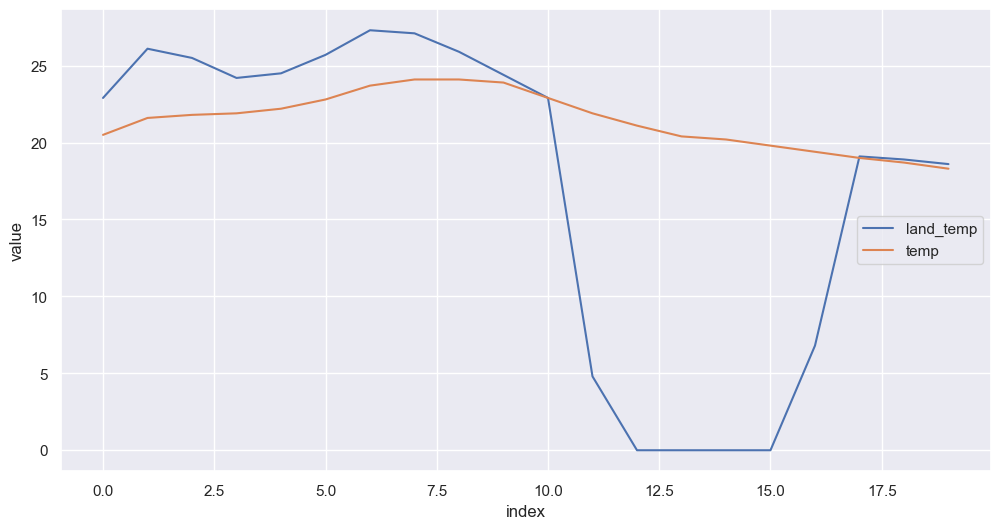

In [19]:
data = test_df[5410:5430].reset_index(drop = True)
sns.set(style='darkgrid')
plt.figure(figsize=(12, 6))
for column in ['land_temp', 'temp']:
    plt.plot(data[column], label=column)
plt.xlabel('index')
plt.ylabel('value')
plt.xticks()
plt.legend(loc = 'right')
plt.show()

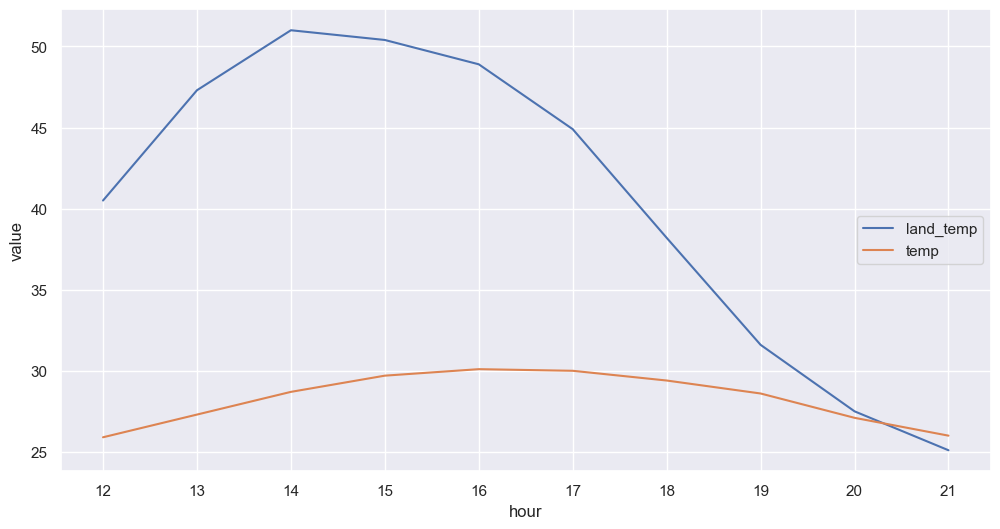

In [20]:
data = test_df[1500:1510].reset_index(drop=True)
data['humid'] = data['humid'] * 10
sns.set(style='darkgrid')
plt.figure(figsize=(12, 6))
x = range(len(data))  # x값으로 사용할 범위 생성
plt.plot(x, data['land_temp'], label='land_temp')
plt.plot(x, data['temp'], label='temp')
plt.xlabel('hour')
plt.ylabel('value')
plt.xticks(x, data['hour'])  # x축 눈금 레이블 설정
plt.legend(loc='right')
plt.show()

검증

In [ ]:
# 검증 데이터
surface = pd.read_csv('imputed_test_data.csv')
surface['area'] = surface['area'].astype(int)
surface['month'] = surface['month'].astype(int)
surface['day'] = surface['day'].astype(int)
surface['hour'] = surface['hour'].astype(int)
surface_fe = feature_extraction(original_df = surface)
#'temp', 'dp_temp', 'humid' 3개 변수에 대해 1, 2, 12, 24 lag 변수와 해당 lag의 percentage change 추가 + 기타 lag 변수들과 interaction들 추가
surface_lag = add_lag(original_df = surface_fe, 
                      lag_cols = ['temp', 'dp_temp', 'humid', 'wind', 'rain', 'tf_rain', 'solar_amt', 'solar_time'], #lag 추가하는 변수들 
                      pct_cols = ['temp', 'dp_temp', 'humid'], #percetnage change 추가하는 변수들 
                      lags = [1, 3, 6, 12, 24]) #추가 lag들 
#summer: 맑음 / 비 / 기타 구분 & snow에 대한 adjustment x 
f = {x:3 for x in surface.fog.unique()} 
f.update({'C': 1, 'R':2})
summer_test = make_weather_df(original_df = surface_lag, 
                         weather = 'summer', 
                         adj = False, 
                         fog_split = f)

In [76]:
dat = pd.read_excel('subminssionUser.xlsx', sheet_name=None)['SPRING']

In [77]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405 entries, 0 to 6404
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STN     6405 non-null   object 
 1   YEAR    6405 non-null   object 
 2   MMDDHH  6405 non-null   int64  
 3   TS      0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 200.3+ KB


In [78]:
summer_test['MMDDHH'] = summer_test['month'].astype('str') + summer_test['day'].astype('str').str.zfill(2) + summer_test['hour'].astype('str').str.zfill(2)
summer_test['MMDDHH'] = summer_test['MMDDHH'].astype('int64')

In [79]:
summer_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624 entries, 0 to 6623
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area                  6624 non-null   int32  
 1   year                  6624 non-null   object 
 2   month                 6624 non-null   int32  
 3   day                   6624 non-null   int32  
 4   hour                  6624 non-null   int32  
 5   temp                  6624 non-null   float64
 6   dp_temp               6624 non-null   float64
 7   humid                 6624 non-null   float64
 8   wind                  6624 non-null   float64
 9   rain                  6624 non-null   float64
 10  tf_rain               6624 non-null   float64
 11  solar_amt             6624 non-null   float64
 12  solar_time            6624 non-null   float64
 13  hour_sin              6624 non-null   float64
 14  hour_cos              6624 non-null   float64
 15  day_cos              

In [91]:
summer_test[summer_test['area'] == 1][~summer_test['MMDDHH'].isin(dat[dat['STN'] == 'a']['MMDDHH'])]

,area,year,month,day,hour,temp,dp_temp,humid,wind,rain,...,humid_lag_24,rain_count,solar_amt_sum,after_rain,temp_after_rain,solar_amt_after_rain,fog_1,fog_2,fog_3,MMDDHH
879,1,F,6,6,15,21.384031,11.518695,0.543790,3.398850,0.0,...,0.519,1,9.89,6,128.304188,18.90,1,0,0,60615
880,1,F,6,6,16,21.379780,11.450978,0.530577,3.220916,0.0,...,0.544,2,8.28,7,149.658459,11.55,1,0,0,60616


In [93]:
summer_test[summer_test['area'] == 2][~summer_test['MMDDHH'].isin(dat[dat['STN'] == 'b']['MMDDHH'])]

,area,year,month,day,hour,temp,dp_temp,humid,wind,rain,...,humid_lag_24,rain_count,solar_amt_sum,after_rain,temp_after_rain,solar_amt_after_rain,fog_1,fog_2,fog_3,MMDDHH
3084,2,F,6,6,12,19.323002,15.881842,0.806088,2.006141,0.0,...,0.688,0,2.08,6,115.938011,4.14,0,0,1,60612
3180,2,F,6,10,12,27.575895,16.916651,0.527948,2.013808,0.0,...,0.570,0,8.09,0,0.000000,0.00,1,0,0,61012


In [92]:
summer_test[summer_test['area'] == 3][~summer_test['MMDDHH'].isin(dat[dat['STN'] == 'c']['MMDDHH'])]

,area,year,month,day,hour,temp,dp_temp,humid,wind,rain,...,humid_lag_24,rain_count,solar_amt_sum,after_rain,temp_after_rain,solar_amt_after_rain,fog_1,fog_2,fog_3,MMDDHH
5292,3,F,6,6,12,22.681553,16.841887,0.689864,3.127376,0.045974,...,0.994,1,5.52,4,90.726212,6.8,1,0,0,60612


In [109]:
pd.DataFrame(y_test_pred2).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624 entries, 0 to 6623
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6624 non-null   float64
dtypes: float64(1)
memory usage: 51.9 KB


In [101]:
# Single LGBM model with cv = 3
pred1 = pd.DataFrame(y_test_pred1).drop([879, 880, 3084, 3180, 5292], axis = 0)
pred1.to_csv('summer_pred11111.csv', index = False)

In [102]:
# Single LGBM model with cv = 7
pred2 = pd.DataFrame(y_test_pred2).drop([879, 880, 3084, 3180, 5292], axis = 0)
pred2.to_csv('summer_pred22222.csv', index = False)

In [103]:
# Ensemble model without area = 3 model
pred3 = pd.DataFrame(y_test_pred3).drop([879, 880, 3084, 3180, 5292], axis = 0)
pred3.to_csv('summer_pred33333.csv', index = False)

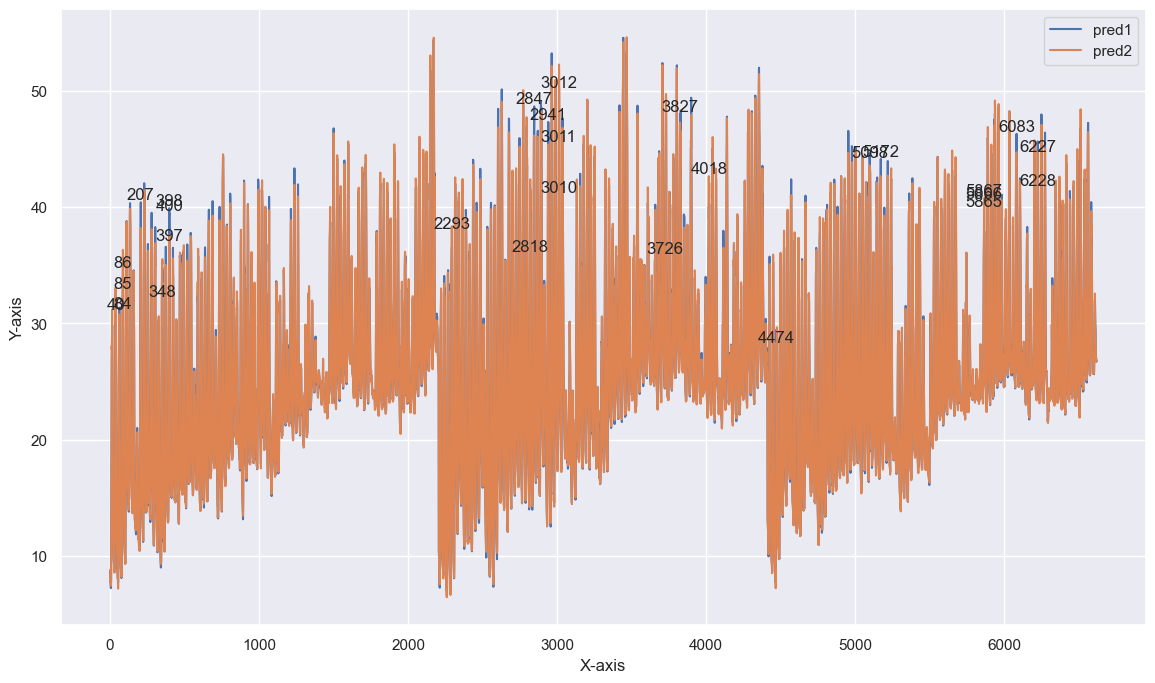

In [349]:
# 그래프 그리기
plt.figure(figsize=(14, 8))
plt.plot(x, pred1, label='pred1')
plt.plot(x, pred2, label='pred2')

# 값이 2 이상 차이나는 경우 인덱스 표시
for i in range(len(x)):
    if abs(np.array(pred1)[i] - np.array(pred2)[i]) >= 2:
        plt.text(x[i], max(np.array(pred1)[i], np.array(pred2)[i]), str(i+1), ha='center', va='bottom')

# 그래프 스타일 및 범례 설정
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 그래프 출력
plt.show()

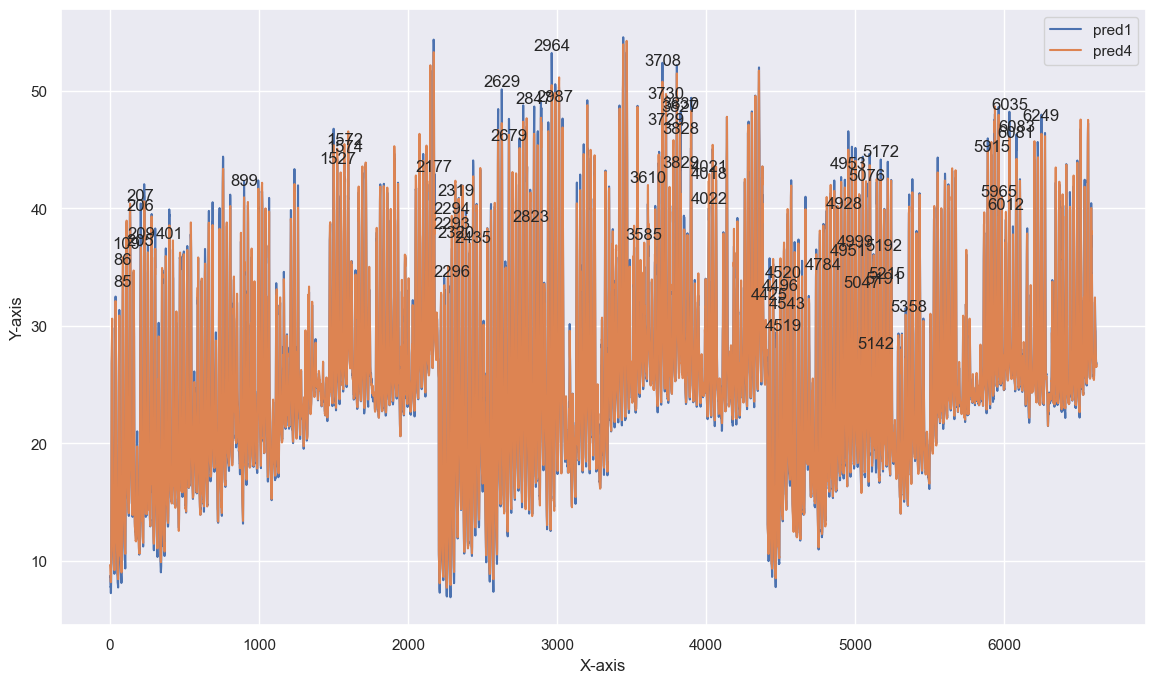

In [350]:
# 그래프 그리기
plt.figure(figsize=(14, 8))
plt.plot(x, pred1, label='pred1')
plt.plot(x, pred4, label='pred4')

# 값이 2 이상 차이나는 경우 인덱스 표시
for i in range(len(x)):
    if abs(np.array(pred1)[i] - np.array(pred4)[i]) >= 2:
        plt.text(x[i], max(np.array(pred1)[i], np.array(pred4)[i]), str(i+1), ha='center', va='bottom')

# 그래프 스타일 및 범례 설정
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 그래프 출력
plt.show()